# Assignment 1 CAP 5516, Chest X-Ray classification

## Problem statement: Assume ResNet-18 is used as the network backbone, please complete the following two sub-tasks.

### Task 1.1
Train the model (e.g., ResNet-18) from scratch (i.e., random initialization of the model parameters) using the training X-ray images.

### Task 1.2
Leverage the pre-trained ResNet-18 (the same CNN used in Task 1.1) model on the ImageNet and fine tune the model on the target X-ray images (training set).

### Note
By using the techniques learned from class (e.g., data augmentation, model regularization, etc.), the goal is to achieve the best testing accuracy you can for Task 1.1 and Task 1.2. More training tricks or good practices can be found in [2].

In [2]:
import glob
import matplotlib.pyplot as plt
import cv2

## Explore data

In [2]:
!ls data/chest_xray/

test  train  val


In [3]:
train_fnames = glob.glob("data/chest_xray/train/*/*")
len(train_fnames)

5216

In [4]:
val_fnames = glob.glob("data/chest_xray/val/*/*")
len(val_fnames)

16

The size of the validation set is very small; we should redistribute the samples between the training and validation set so that more samples are used for validation. This is done in dataset.py

In [5]:
test_fnames = glob.glob("data/chest_xray/test/*/*")
len(test_fnames)

624

In [6]:
f"Number of samples: {len(train_fnames) + len(val_fnames) + len(test_fnames)}"

'Number of samples: 5856'

In [8]:
train_normal = [f for f in train_fnames if 'NORMAL' in f]
n_normal = len(train_normal)
n_normal

1341

In [9]:
train_pneumonia = [f for f in train_fnames if 'NORMAL' not in f]
n_pneumonia = len(train_pneumonia)
assert len(train_fnames) - n_normal == n_pneumonia
n_pneumonia

3875

Can see that there is a large class imbalance, many more pneumonia than healthy images, need to do data augmentation or some sampling to fix this ratio

### Data visualization

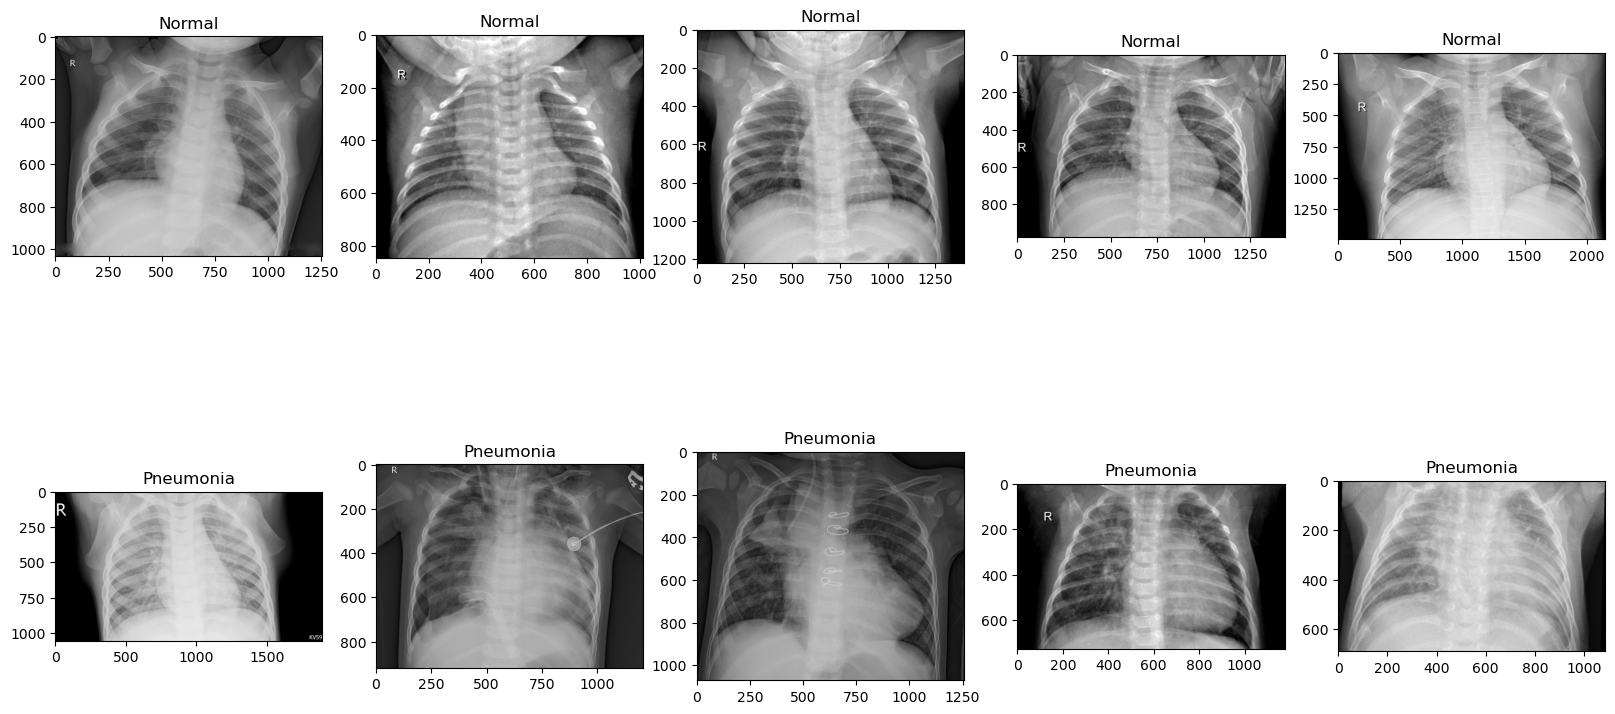

In [10]:
# Show 10 sample train images, 5 normal and 5 pneumonia
fig, axes = plt.subplots(2, 5, figsize=(20, 10))
axes = axes.flatten()
for img, ax in zip(train_normal[:5], axes[:5]):
    bgr_img = cv2.imread(img)
    rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
    ax.imshow(rgb_img)
    ax.set_title('Normal')
for img, ax in zip(train_pneumonia[:5], axes[5:]):
    bgr_img = cv2.imread(img)
    rgb_img = cv2.cvtColor(bgr_img, cv2.COLOR_BGR2RGB)
    ax.imshow(rgb_img)
    ax.set_title('Pneumonia')

We see that the image size is not consistent, so maybe we should normalize to have a consistent size in our pytorch transform

### Create pytorch datasets
Note, some of this code is adapted from https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [4]:
import torch

In [12]:
# Baseline training from bag of tricks paper
# 1. Randomly sample an image and decode it into 32-bit
# floating point raw pixel values in [0, 255].
# 2. Randomly crop a rectangular region whose aspect ratio
# is randomly sampled in [3/4, 4/3] and area randomly
# sampled in [8%, 100%], then resize the cropped region
# into a 224-by-224 square image.
# 3. Flip horizontally with 0.5 probability.
# 4. Scale hue, saturation, and brightness with coefficients
# uniformly drawn from [0.6, 1.4].
# 5. Add PCA noise with a coefficient sampled from a nor-
# mal distribution N (0, 0.1).

In [5]:
import dataset
import importlib
importlib.reload(dataset)

<module 'dataset' from '/home/nashir/Documents/UCF/spring2023/cap5516/assignment-1/dataset.py'>

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataloaders, dataset_sizes, class_names = dataset.load_xray_data()

In [7]:
class_names

['NORMAL', 'PNEUMONIA']

### Visualize images from the torch dataset with transforms

In [10]:
# Compute approximate mean and std of train dataset based on a single batch
images, _ = next(iter(dataloaders['train']))
# shape of images = [b,c,w,h]
mean, std = images.mean([0,2,3]), images.std([0,2,3])

In [11]:
mean, std

(tensor([0.5563, 0.5563, 0.5563]), tensor([0.1765, 0.1765, 0.1765]))

In [12]:
## Reload dataset with mean and std for transforms
dataloaders, dataset_sizes, class_names = dataset.load_xray_data(dataset.get_baseline_transforms(mean, std))

In [13]:
import viz

importlib.reload(viz)

<module 'viz' from '/home/nashir/Documents/UCF/spring2023/cap5516/assignment-1/viz.py'>

In [14]:
import torchvision

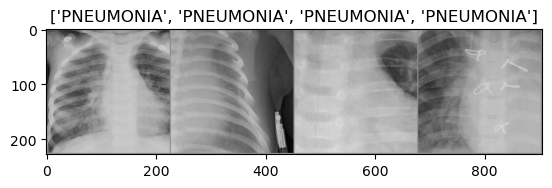

In [15]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

viz.imshow(out, mean, std, title=[class_names[x] for x in classes])


In [16]:
import train

### Train a simple baseline model from scratch as first approach

In [17]:
from torchvision.models import resnet18, ResNet18_Weights
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

In [18]:
n_outputs = 2

In [73]:
model_scratch = resnet18(weights=None)
# Change the output layer to have 2 outputs
num_ftrs = model_scratch.fc.in_features
model_scratch.fc = torch.nn.Linear(num_ftrs, n_outputs)
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_scratch = optim.SGD(model_scratch.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_scratch, step_size=7, gamma=0.1)

In [74]:
model_scratch, hist_scratch = train.train_model(
    model_scratch, criterion, optimizer_scratch, exp_lr_scheduler,
    dataloaders, dataset_sizes, num_epochs=20)

Epoch 1/20
----------
train Loss: 0.5484 Acc: 0.7596
val Loss: 0.3871 Acc: 0.8338

Epoch 2/20
----------
train Loss: 0.4200 Acc: 0.8131
val Loss: 0.3246 Acc: 0.8768

Epoch 3/20
----------
train Loss: 0.3825 Acc: 0.8323
val Loss: 0.2923 Acc: 0.8835

Epoch 4/20
----------
train Loss: 0.3468 Acc: 0.8559
val Loss: 0.2511 Acc: 0.8968

Epoch 5/20
----------
train Loss: 0.3363 Acc: 0.8569
val Loss: 0.3478 Acc: 0.8520

Epoch 6/20
----------
train Loss: 0.3056 Acc: 0.8619
val Loss: 0.2766 Acc: 0.8863

Epoch 7/20
----------
train Loss: 0.2952 Acc: 0.8798
val Loss: 0.3006 Acc: 0.8816

Epoch 8/20
----------
train Loss: 0.2324 Acc: 0.9094
val Loss: 0.2146 Acc: 0.9131

Epoch 9/20
----------
train Loss: 0.2261 Acc: 0.9097
val Loss: 0.2236 Acc: 0.9054

Epoch 10/20
----------
train Loss: 0.2250 Acc: 0.9051
val Loss: 0.2451 Acc: 0.9160

Epoch 11/20
----------
train Loss: 0.2112 Acc: 0.9185
val Loss: 0.2319 Acc: 0.9160

Epoch 12/20
----------
train Loss: 0.2262 Acc: 0.9070
val Loss: 0.2145 Acc: 0.9121

E

### Analyze baseline model performance

In [75]:
train_loss_scratch, train_acc_scratch, val_loss_scratch, val_acc_scratch = hist_scratch

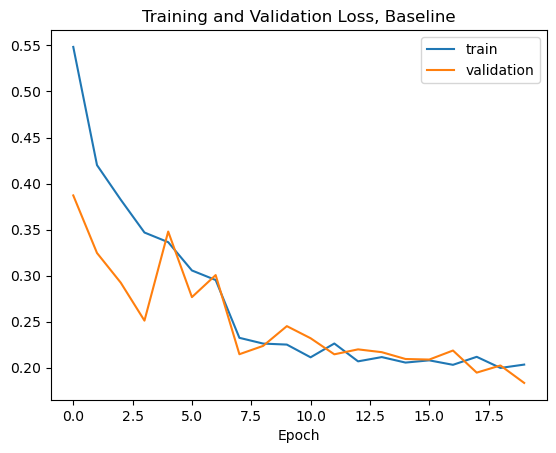

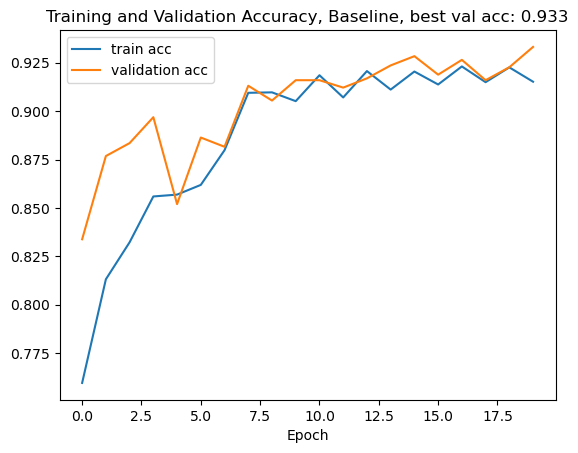

In [76]:
viz.plot_training_metrics(train_loss_scratch, train_acc_scratch, val_loss_scratch, val_acc_scratch, title="Baseline")

Seems like the model didn't plateau or overfit. Could probably train for more epochs to improve accuracy

### Save model

In [113]:
# Save model
torch.save(model_scratch.state_dict(), 'models/baseline.pth')

### Load model

In [21]:
# Load model
model_scratch = resnet18(weights=None)
# Change the output layer to have 2 outputs
num_ftrs = model_scratch.fc.in_features
model_scratch.fc = torch.nn.Linear(num_ftrs, n_outputs)
model_scratch.load_state_dict(torch.load('models/baseline.pth'))

<All keys matched successfully>

### Evaluate model on test set

In [33]:
importlib.reload(train)

<module 'train' from '/home/nashir/Documents/UCF/spring2023/cap5516/assignment-1/train.py'>

In [34]:
test_accuracy_base, per_class_acc_base, confusion_base = train.evaluate_model(model_scratch, data_loader=dataloaders['test'], class_names=class_names)

Accuracy for class: NORMAL is 78.2 %
Accuracy for class: PNEUMONIA is 96.2 %

 Overall accuracy (Test dataset): 89.4


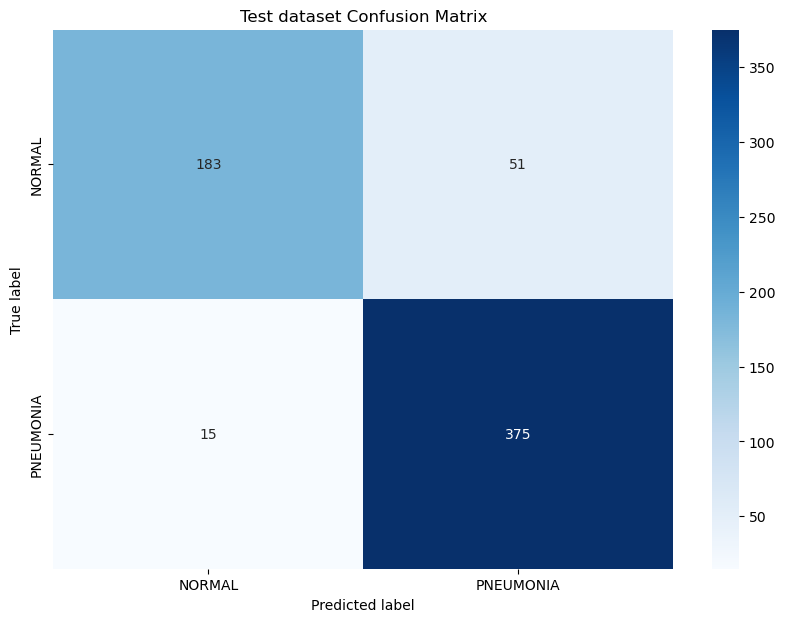

In [37]:
viz.show_test_summary_metrics(test_accuracy_base, per_class_acc_base, confusion_base, "Test dataset", class_names)

These results indicate data imbalance leading to poor accuracy because the model over predicts pneumonia, since it sees more of these examples during training.

## Task 1.1
Train the model (e.g., ResNet-18) from scratch (i.e., random initialization of the model parameters) using the training X-ray images.

#### To improve model accuracy:
1. Use traditional data augmentation
2. Use Cutmix
3. Address data imbalance

#### Balance data using oversampling (https://arxiv.org/abs/1710.05381)

In [1]:
dataloaders_b, dataset_sizes_b, class_names = dataset.load_oversampled_xray_data(dataset.get_baseline_transforms(mean, std))

NameError: name 'dataset' is not defined

## TODO(): add cross validation

## Task 1.2
Leverage the pre-trained ResNet-18 (the same CNN used in Task 1.1) model on the ImageNet and fine tune the model on the target X-ray images (training set).

In [14]:
model_ft = resnet18(weights=ResNet18_Weights.DEFAULT)

# Analysis

### Gradcam

### Filter visualization

### Nearest Neighbors on last layer

### Dimensionality reduction on samples from last layer visualized with PCA and t-SNE